## CSC 722 - Naive Bayes

**Environment Details**: 
- **OS**: OpenSUSE Tumbleweed (x86_64)
- **Python version**: 3.11.6
- **Jupyter-Lab version**: 4.0.9
***

### Pre-task setup

In [1]:
# Imports
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Natural Language Toolkit
import nltk
# (Uncomment if needed) Force a download of our nltk packages if this is the first time running the notebook
##nltk.download('stopwords')
##nltk.download('punkt')
from nltk.corpus import stopwords
# sent_tokenizer docs here: https://www.nltk.org/api/nltk.tokenize.sent_tokenize.html
from nltk.tokenize import sent_tokenize
# PorterStemmer() docs here: https://www.nltk.org/_modules/nltk/stem/porter.html
from nltk.stem import PorterStemmer

# Scikit-Learn imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Nicer Jupyter output formatting
import ipywidgets as widgets

# Quiet filter warnings
import warnings
warnings.filterwarnings('ignore')

### 0) DataFrame Creation

In [2]:
# Load our tweets CSV data into a Pandas DataFrame
# Data set location: https://www.kaggle.com/datasets/vstepanenko/disaster-tweets/
df = pd.read_csv('tweets.csv')

In [3]:
# Ensure our data loaded correctly
df.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


### 1) Exploratory Data Analysis

In [4]:
# Look at information aboud our dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


In [5]:
# Look at summary statistics of our dataset
df.describe()

,id,target
count,11370.000000,11370.000000
mean,5684.500000,0.185928
std,3282.380615,0.389066
min,0.000000,0.000000
25%,2842.250000,0.000000
50%,5684.500000,0.000000
75%,8526.750000,0.000000
max,11369.000000,1.000000


In [6]:
# Examine unique keywords
df.keyword.value_counts()

keyword
thunderstorm     93
flattened        88
mass%20murder    86
stretcher        86
drown            83
                 ..
electrocuted     16
rainstorm        11
siren            10
deluged          10
tsunami           6
Name: count, Length: 219, dtype: int64

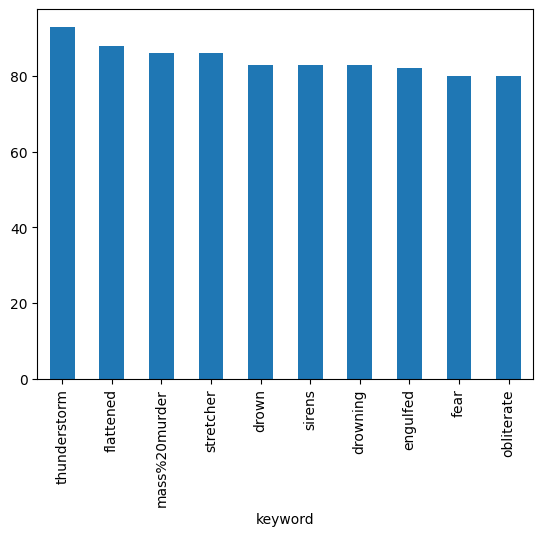

In [7]:
# Plot the frequency counts of the top 10 values
t10 = (df['keyword'].value_counts()).iloc[:10]
t10.plot(kind='bar')
plt.show()

### 2) Text pre-processing, tokenization, & stemming
**Instructions**: I would like you to do some text preprocessing. At a minimum, remove punctuation and stopwords, and make all text lowercase. If you wish to add more stopwords or modify the text further to achieve better results (such as stemming), let me know what you did in the comments when submitting to the Dropbox and I would give extra credit. Remember you have multiple books you can use to aid you in this.

**Note**: I'm using the nltk sentence tokenizer and the PorterStemmer() class to stem the text in the function below.

I decided to use the sentence tokenizer {`sent_tokenize()`} rather than word tokenizer {`word_tokenize()`}.

From testing, the sentence tokenizer gave slightly better model precision/recall than word tokenizer which makes sense, since we're processing full sentences from tweets, rather than random individual words

In [8]:
# Create our PorterStemmer object
ps = PorterStemmer()

# Remove stopwords & punctuation, convert everything to lowercase, also tokenize/stem text
def preprocess_text(msg):
    STOPWORDS = stopwords.words('english')
    #STOPWORDS += ['', '', ''] # Placeholder: In case we want to add more custom stopwords
    nopunc = [char for char in msg if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    nopunc = ' '.join([word.lower() for word in nopunc.split() if word not in STOPWORDS])
    # Tokenize using the NLTK sentence tokenizer
    words = sent_tokenize(nopunc)
    # Stem our text
    stemmed = [ps.stem(word) for word in words]
    stemmed = ' '.join(stemmed)
    return stemmed

In [9]:
# Create a new column to our dataframe for cleaned text
df['clean_text'] = df.text.apply(preprocess_text)

In [10]:
# Examine our cleaned text
df.head()

,id,keyword,location,text,target,clean_text
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1,communal violence bhainsa telangana stones pel...
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1,telangana section 144 imposed bhainsa january ...
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1,arsonist sets cars ablaze dealership httpstcog...
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1,arsonist sets cars ablaze dealership httpstco0...
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0,lord jesus love brings freedom pardon fill hol...


### 3) Frequency Table & MultinomialNB
**Instructions**: Finally, after the text has been processed, transform it to a frequency table and use it with a MultinomialNB model to classify the tweets as either referencing a real disaster (given as a 1 in the target column) or not.

In [11]:
# Break out our data sets into X & y sets
X = df.clean_text
y = df.target

In [12]:
# Ensure our data sets split out correctly
print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))

X shape: (11370,)
y shape: (11370,)


In [13]:
# Split our data into training & test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Validate that our training & test data split out correctly
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (8527,)
X_test shape: (2843,)
y_train shape: (8527,)
y_test shape: (2843,)


In [14]:
# Initialize our CountVectorizer object
vect = CountVectorizer()

# Fit our training data
vect.fit(X_train)

CountVectorizer()

In [15]:
# Transform our training data into a frequency table (sparse matrix)
X_train_dtm = vect.transform(X_train)
print(X_train_dtm.shape)

(8527, 23619)


In [16]:
# Transform our testing data into a frequency table (sparse matrix)
X_test_dtm = vect.transform(X_test)
print(X_test_dtm.shape)

(2843, 23619)


In [17]:
# Create our MultinomialNB object
# Documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
nb = MultinomialNB()

In [18]:
# Fit our transformed X training data
nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [19]:
# Let's make some predictions
y_pred = nb.predict(X_test_dtm)

# Output specific accuracy, precision, recall, & F1 metrics for our model:
print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred)))
print("Precision: {}".format(metrics.precision_score(y_test, y_pred, average='macro')))
print("Recall: {}".format(metrics.recall_score(y_test, y_pred, average='macro')))
print("F1 Score: {}".format(metrics.f1_score(y_test, y_pred, average='macro')))

Accuracy: 0.8979950756243404
Precision: 0.8494846577584818
Recall: 0.7713082607615964
F1 Score: 0.8021054157641673


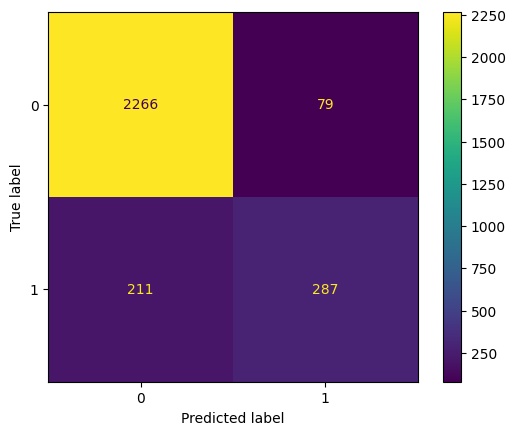

In [20]:
# Display our Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

### 4) GridSearchCV
**Instructions**: Use GridSearchCV with multiple parameters to get the best model you can, and then choosing the best, show the all the metrics we care about (precision, recall, accuracy, F1).

In [21]:
# Instantiate our Naive Bayes object
mnb = MultinomialNB()

# Set up multiple alpha parameters to test with our Grid Search
params = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'force_alpha': (True, False),
    'fit_prior': (True, False),
    'class_prior': (None, 0.25, 0.75)
}  

# Instantiate our Grid Search object
grid_search = GridSearchCV(mnb, params)

# Run our grid search on the training data
grid_search.fit(X_train_dtm, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05),
                         'class_prior': (None, 0.25, 0.75),
                         'fit_prior': (True, False),
                         'force_alpha': (True, False)})

In [22]:
# View additional details from our grid search
print("Best parameters: {}".format(grid_search.best_params_))
print("Best estimator: {}".format(grid_search.best_estimator_))
print("Best score: {}".format(grid_search.best_score_))

Best parameters: {'alpha': 1, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}
Best estimator: MultinomialNB(alpha=1, force_alpha=True)
Best score: 0.8508265806726646


In [23]:
# Use our best estimator
model = grid_search.best_estimator_

# Make a prediction using the 'X_test' data set
y_pred = model.predict(X_test_dtm)

In [24]:
# Output specific accuracy, precision, recall, & F1 metrics for our model:
print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred)))
print("Precision: {}".format(metrics.precision_score(y_test, y_pred, average='macro')))
print("Recall: {}".format(metrics.recall_score(y_test, y_pred, average='macro')))
print("F1 Score: {}".format(metrics.f1_score(y_test, y_pred, average='macro')))

Accuracy: 0.8979950756243404
Precision: 0.8494846577584818
Recall: 0.7713082607615964
F1 Score: 0.8021054157641673


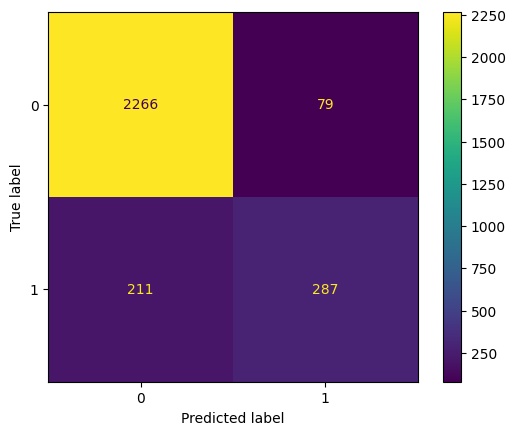

In [25]:
# Display our Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

### 5) Final Model Analysis & Summary

It appears that our original model's fit using the default `MultinomialNB()` parameters was the best estimator. 

No parameter changes or confusion matrix improvements were observed after running our grid search in step 4.

As seen above, our best estimator model ended up with these metrics (rounded to nearest tenth):
* Accuracy: **89.8%**
* Precision: **84.9%**
* Recall: **77.1%**
* F1 Score: **80.2%**